In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from Solver import *
from functools import partial
import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import NeuralNet
import PlotDefault



# Load Data

In [2]:
Ny = 256
L = 50*2*np.pi
H = [1.0, 1.0]               # the rest depths of each layer
kd = 1.0                     # rd
beta = 3.0
rek = 0.3                     # bottom drag rek
U = [0.0, 0.0]
dU = U[0] - U[1] 
F1 = kd/(1 + (H[0]/H[1])**2.0)
F2 = kd/(1 + (H[1]/H[0])**2.0)
beta1, beta2 = beta + F1*dU, beta - F2*dU
hyper_nu, hyper_order = 0.0, 2
Q = 1.0

yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

force = np.zeros((2, Ny))
force[0, :] = -Q * np.sin(2*np.pi*yy/L)
force[1, :] =  Q * np.sin(2*np.pi*yy/L)

    
    
folder_name = "/central/groups/esm/dzhuang/pyqg_run/2layer/nx256beta4rek0p3/"
file_name = 'nx256beta4rek0p3'
start, end, step = 500000, 1000000, 20000
flow_means, flow_zonal_means = preprocess_data(folder_name, file_name, beta, dU, L, start, end, step)
mu_mean, dpv_mean, u_mean, vor_mean, q_mean, psi_mean, flux_mean, psi_var_2_mean = flow_means[:8]
q_zonal_mean, dq_zonal_mean = flow_zonal_means[:2]



# Plot zonal mean q (top and bottom layers)

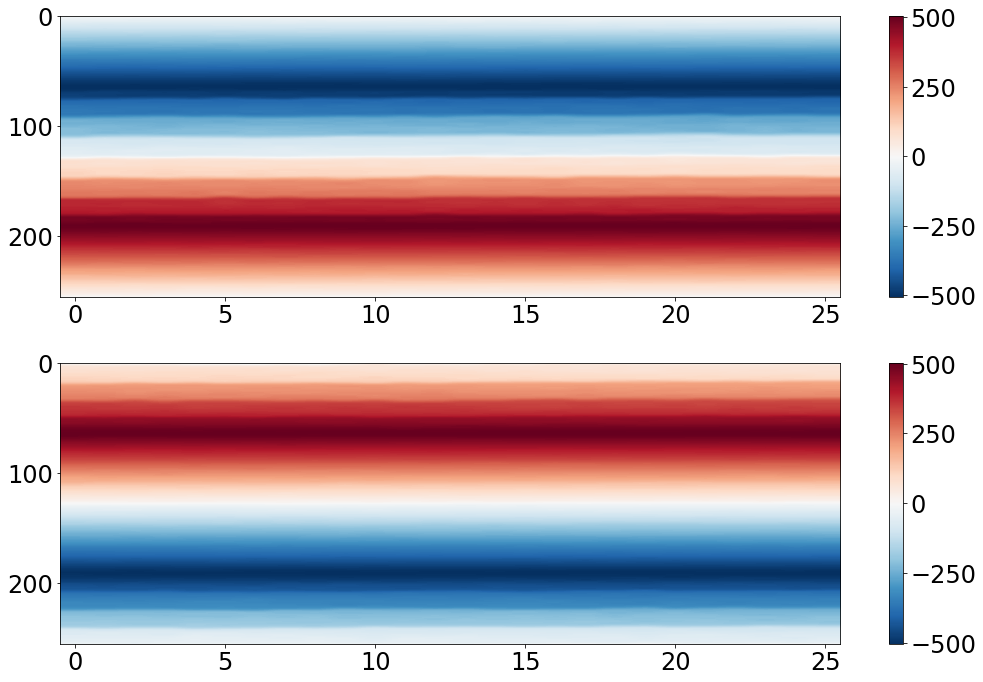

In [3]:
fig, ax = plt.subplots(2,figsize=(15,10))
im0 = ax[0].imshow(q_zonal_mean[:,:,0].T,  aspect='auto', cmap='RdBu_r')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(q_zonal_mean[:,:,1].T,  aspect='auto', cmap='RdBu_r')
fig.colorbar(im1, ax=ax[1])
plt.tight_layout()

In [ ]:
# Plot zonal mean psi (top and bottom layers)

In [ ]:
fig, ax = plt.subplots(2,figsize=(15,10))
im0 = ax[0].imshow(psi_mean[:,:,0].T,  aspect='auto', cmap='RdBu_r')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(q_zonal_mean[:,:,1].T,  aspect='auto', cmap='RdBu_r')
fig.colorbar(im1, ax=ax[1])
plt.tight_layout()

# Plot zonal mean dq (top and bottom layers)

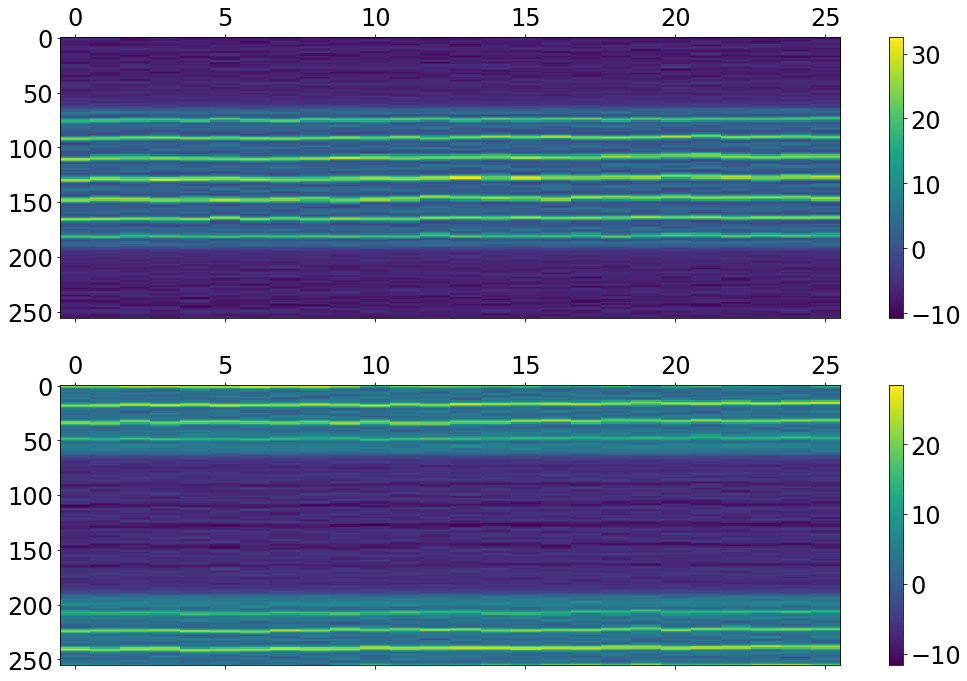

In [9]:
fig, ax = plt.subplots(2,figsize=(15,10))
im0 = ax[0].matshow(dq_zonal_mean[:,:,0].T,  aspect='auto')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].matshow(dq_zonal_mean[:,:,1].T,  aspect='auto')
fig.colorbar(im1, ax=ax[1])
plt.tight_layout()

# Plot top layer time and zonal mean dpv, flux, mu, q

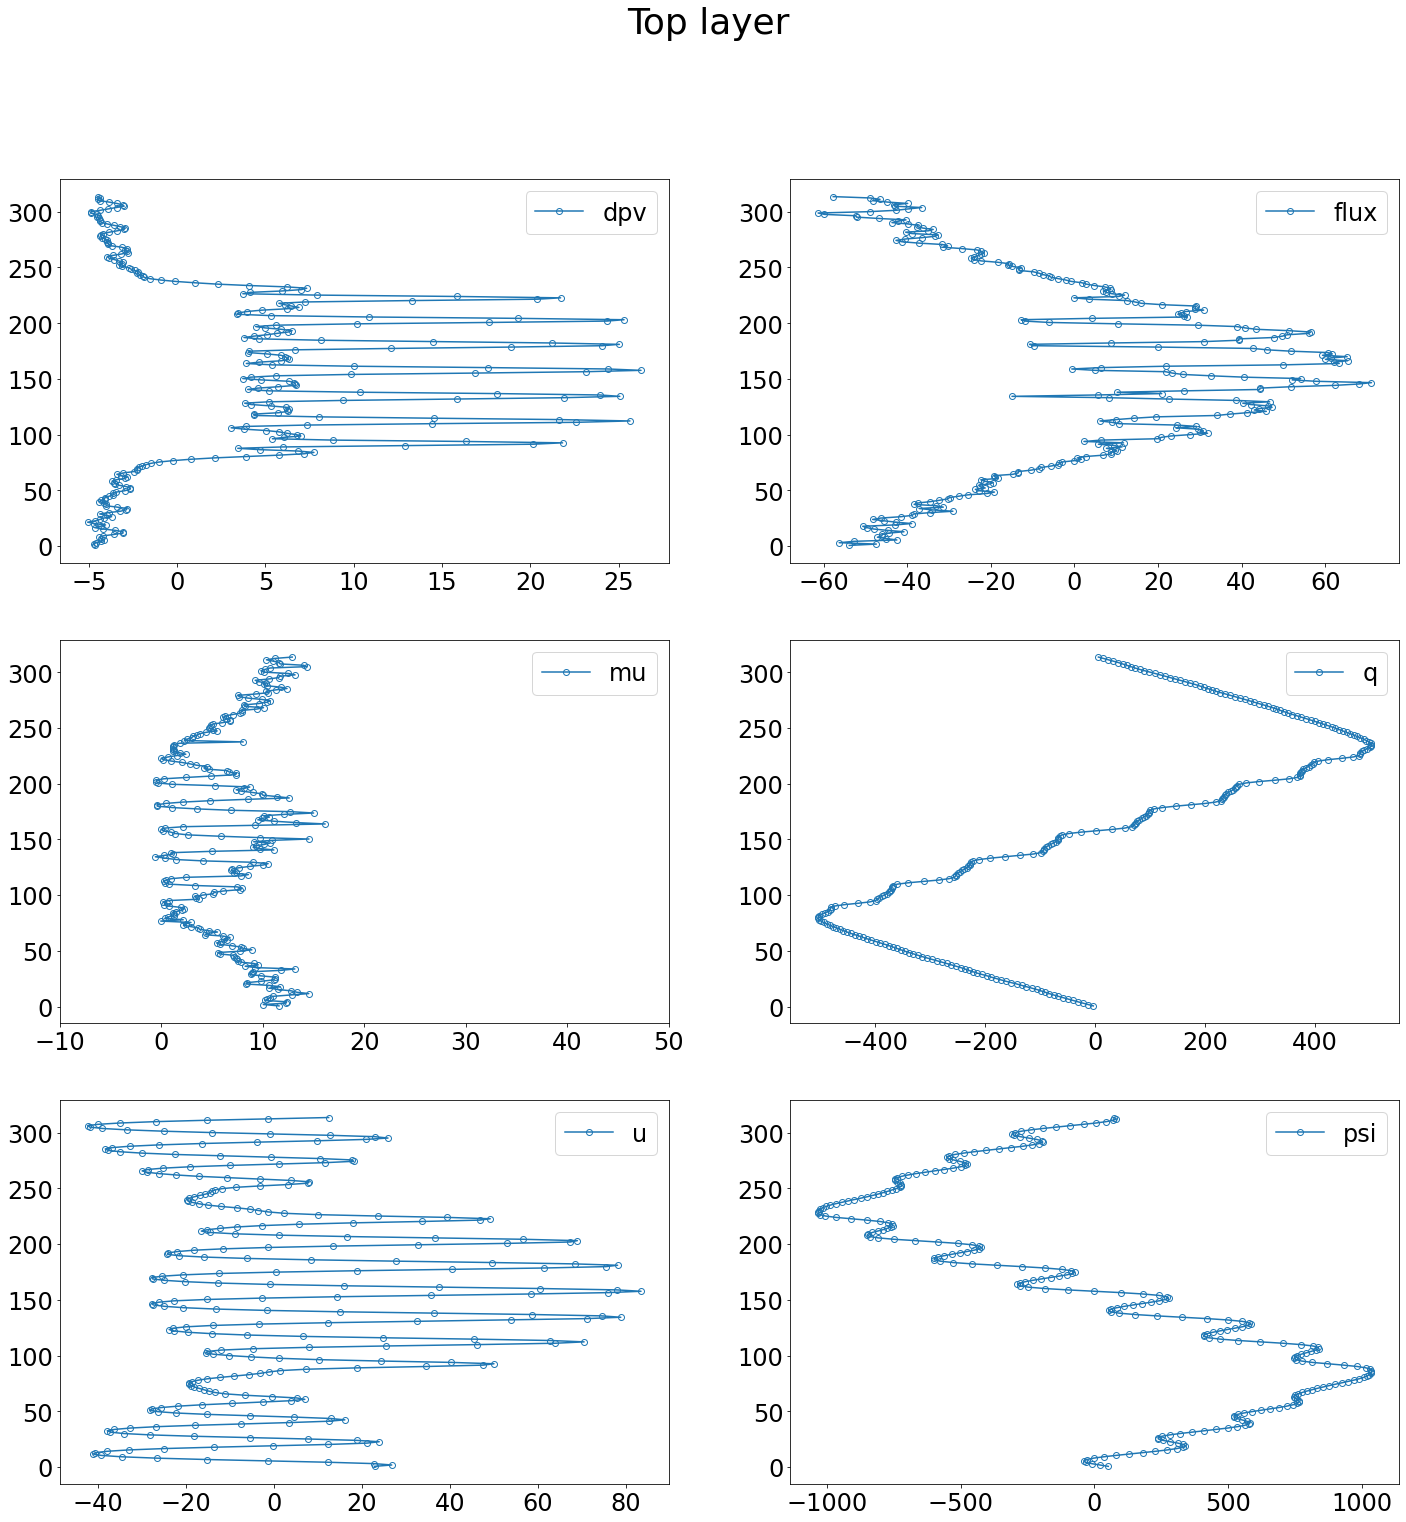

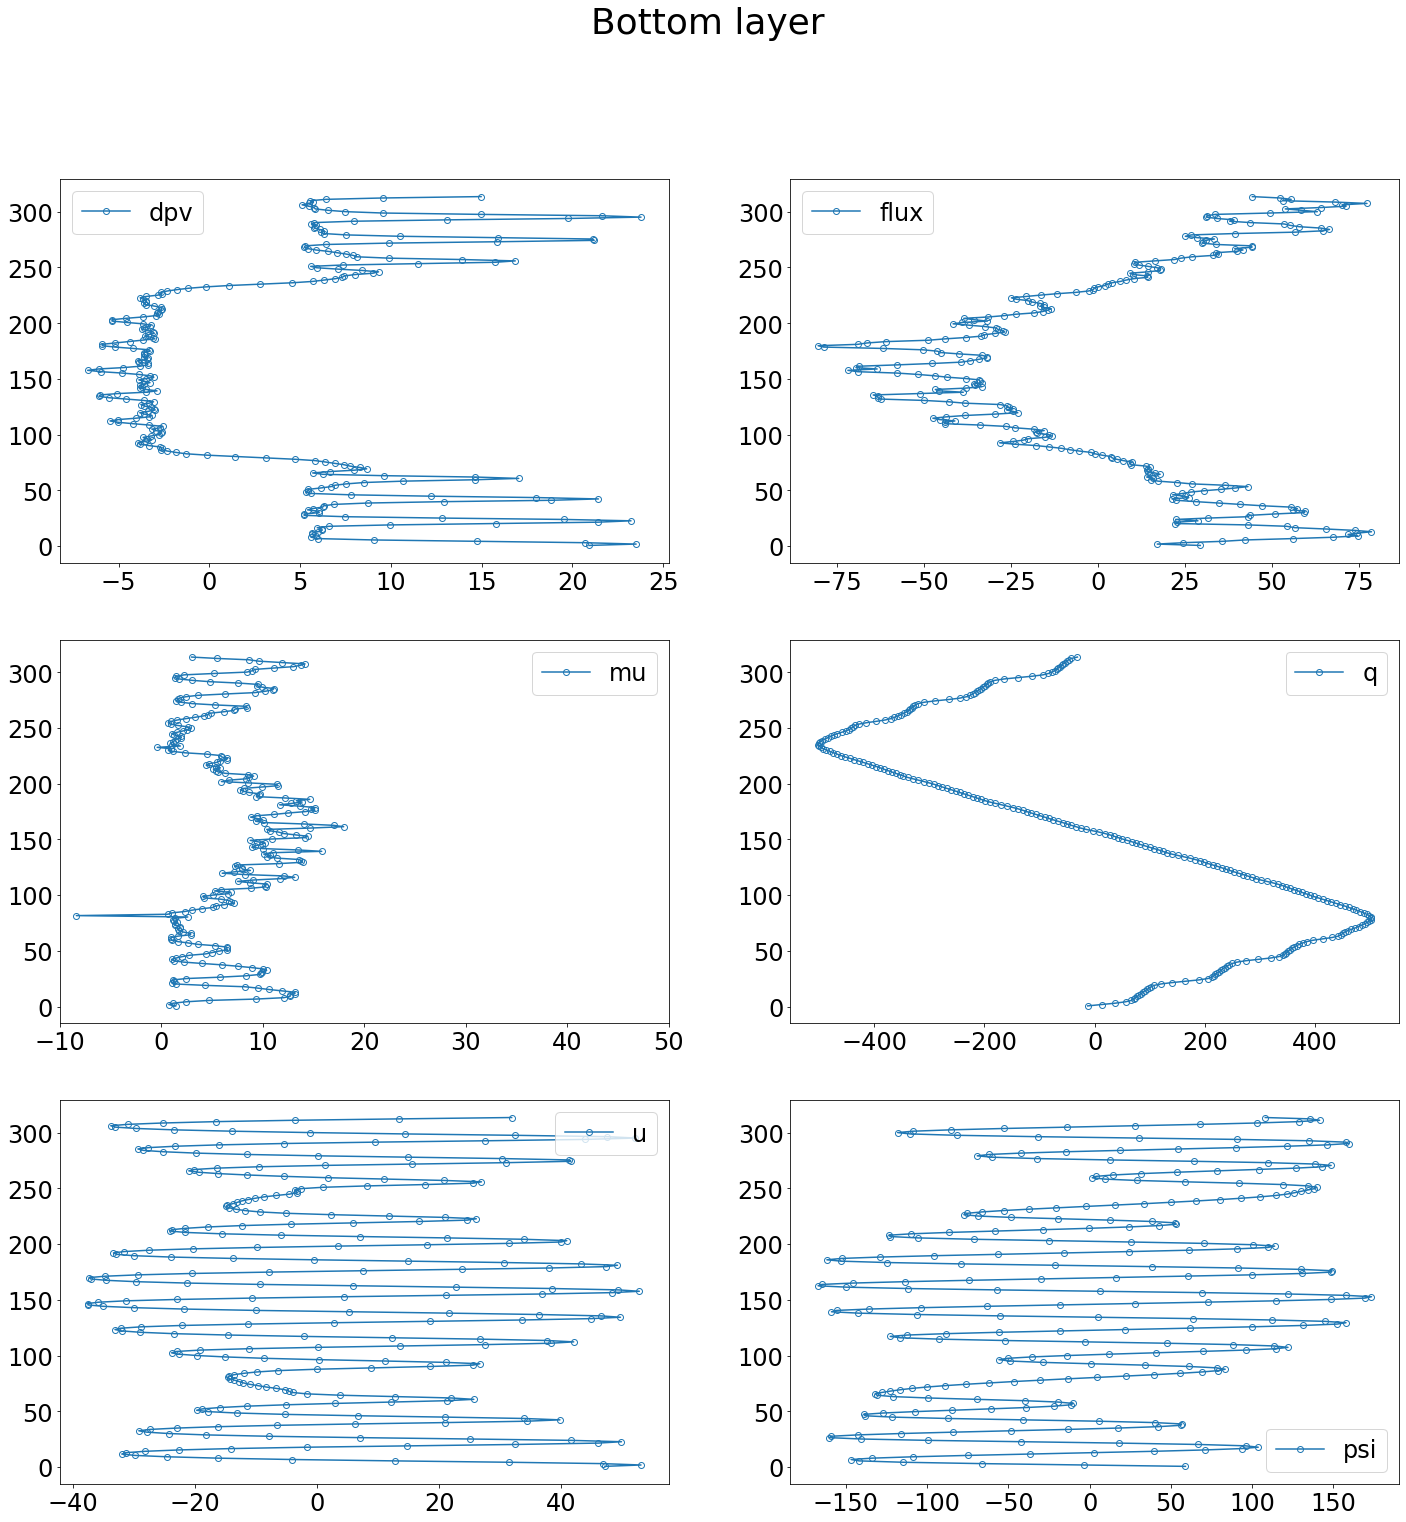

In [10]:
for i in [0]:
    fig, ax = plt.subplots(3,2,figsize=(24,24))
    ax[0,0].plot(dpv_mean[0, :], yy, "-o", fillstyle = "none", label="dpv")
    ax[0,0].legend()
    ax[0,1].plot(flux_mean[0, :], yy, "-o", fillstyle = "none", label="flux")
    ax[0,1].legend()
    ax[1,0].plot(mu_mean[0, :], yy, "-o", fillstyle = "none", label="mu")
    ax[1,0].legend()
    ax[1,0].set_xlim([-10, 50])
    
    ax[1,1].plot(q_mean[0, :], yy, "-o", fillstyle = "none", label="q")
    ax[1,1].legend()
    ax[2,0].plot(u_mean[0, :], yy, "-o", fillstyle = "none", label="u")
    ax[2,0].legend()
    ax[2,1].plot(psi_mean[0, :], yy, "-o", fillstyle = "none", label="psi")
    ax[2,1].legend()
    plt.suptitle("Top layer")
    
    
    fig, ax = plt.subplots(3,2,figsize=(24,24))
    ax[0,0].plot(dpv_mean[1, :], yy, "-o", fillstyle = "none", label="dpv")
    ax[0,0].legend()
    ax[0,1].plot(flux_mean[1, :], yy,"-o", fillstyle = "none", label="flux")
    ax[0,1].legend()
    ax[1,0].plot(mu_mean[1, :], yy,"-o", fillstyle = "none", label="mu")
    ax[1,0].legend()
    ax[1,0].set_xlim([-10, 50])
    ax[1,1].plot(q_mean[1, :], yy,"-o", fillstyle = "none", label="q")
    ax[1,1].legend()
    ax[2,0].plot(u_mean[1, :], yy,"-o", fillstyle = "none", label="u")
    ax[2,0].legend()
    ax[2,1].plot(psi_mean[1, :], yy,"-o", fillstyle = "none", label="psi")
    ax[2,1].legend()
    plt.suptitle("Bottom layer")

# Test flux budget with exact solution

psi error =  0.3369307261613867


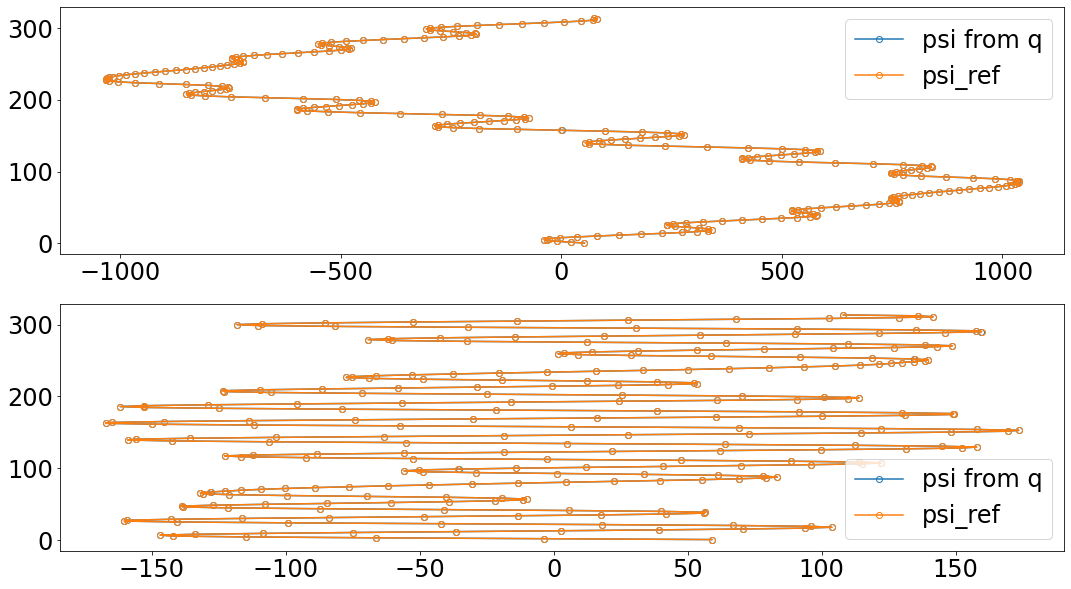

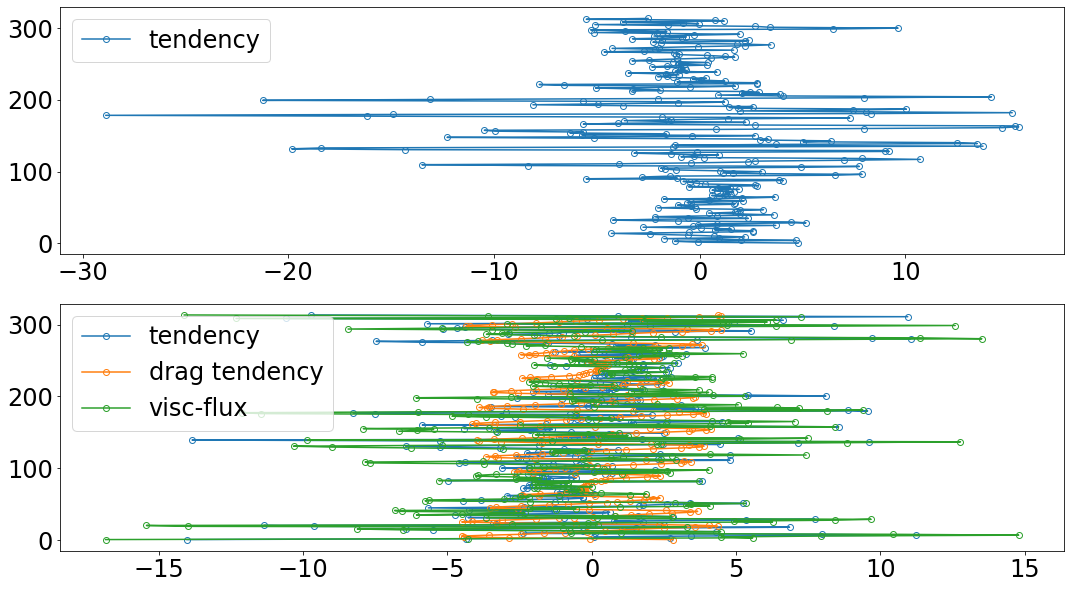

In [6]:
mu_c = np.copy(mu_mean)
mu_c[0,:] = interpolate_f2c(mu_mean[0,:], bc="periodic")
mu_c[1,:] = interpolate_f2c(mu_mean[1,:], bc="periodic")

params = QG_params(L=L, dU=dU, F1=F1, F2=F2, hyper_nu=hyper_nu, hyper_order=hyper_order, beta=beta, rek=rek)

# compute tendency
def mu_model(x):
    return mu_c.flatten()


tend_model = np.zeros((2,Ny))
nummodel(mu_model, beta1, beta2, q_mean, psi_mean, yy, tend_model) 
tend_hyper = hyperdiffusion(q_mean, hyper_nu, hyper_order, dy)
psi_fft_mean = psi_fft_sol(q_mean, F1, F2, dy)




fig, ax = plt.subplots(2,figsize=(18,10))
ax[0].plot(psi_fft_mean[0, :], yy, "-o", fillstyle = "none", label="psi from q")
ax[0].plot(psi_mean[0, :], yy, "-o", fillstyle = "none", label="psi_ref")
ax[0].legend()
ax[1].plot(psi_fft_mean[1, :], yy, "-o", fillstyle = "none", label="psi from q")
ax[1].plot(psi_mean[1, :], yy, "-o", fillstyle = "none", label="psi_ref")
ax[1].legend()

print("psi error = ", np.linalg.norm(psi_fft_mean - psi_mean))



dd_psi2 = gradient_fft(psi_fft_mean[1, :], dy, 2)
tend_drag  = -rek*dd_psi2


fig, ax = plt.subplots(2,figsize=(18,10))
# ax[0].plot(q_mean[0, :], yy, "-o", fillstyle = "none", label="q")
ax[0].plot(tend_model[0, :], yy, "-o", fillstyle = "none", label="tendency")
ax[0].legend()
# ax[1].plot(q_mean[1, :], yy,"-o", fillstyle = "none", label="q")
ax[1].plot(tend_model[1, :] + tend_drag, yy, "-o", fillstyle = "none", label="tendency")
ax[1].plot(tend_drag, yy, "-o", fillstyle = "none", label="drag tendency")
ax[1].plot(tend_model[1, :], yy, "-o", fillstyle = "none", label="visc-flux")
ax[1].legend()
    


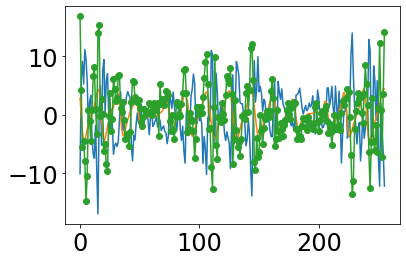

In [7]:
# beta, dU, F1, F2 = params["beta"], params["dU"], params["F1"], params["F2"]
# beta1, beta2 = beta + F1*dU, beta - F2*dU
# beta1, beta2 = beta + F1*dU, beta + F2*dU

dy = yy[1] - yy[0]

q1, q2 = q_mean[0, :], q_mean[1, :]
dq1, dq2 = gradient_first_f2c(q1, dy, bc="periodic"), gradient_first_f2c(q2, dy, bc="periodic")


dflux = gradient_first_f2c(flux_mean[1, :], dy, bc="periodic")
plt.plot(dflux)
plt.plot(tend_drag)
plt.plot(-tend_model[1, :], "-o")

Text(0.5, 1.0, 'plug in tend')

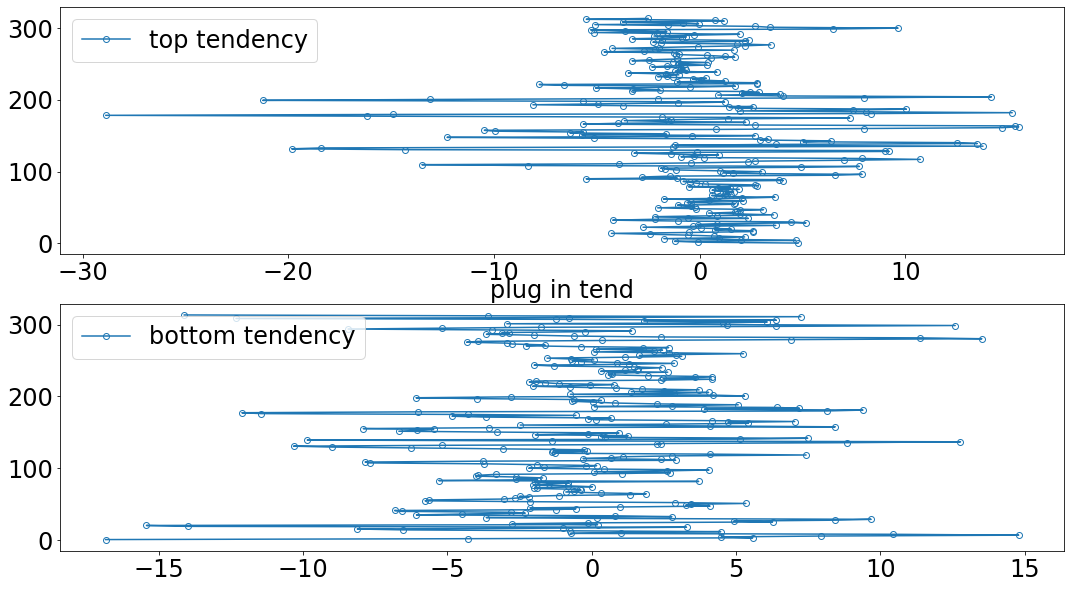

In [8]:
fig, ax = plt.subplots(2,figsize=(18,10))
ax[0].plot(tend_model[0, :], yy, "-o", fillstyle = "none", label="top tendency")
ax[0].legend()
ax[1].plot(tend_model[1, :], yy, "-o", fillstyle = "none", label="bottom tendency")
ax[1].legend()
plt.title("plug in tend")

# Start 1D plug-in simulation

Text(0.5, 1.0, 'plug in mu')

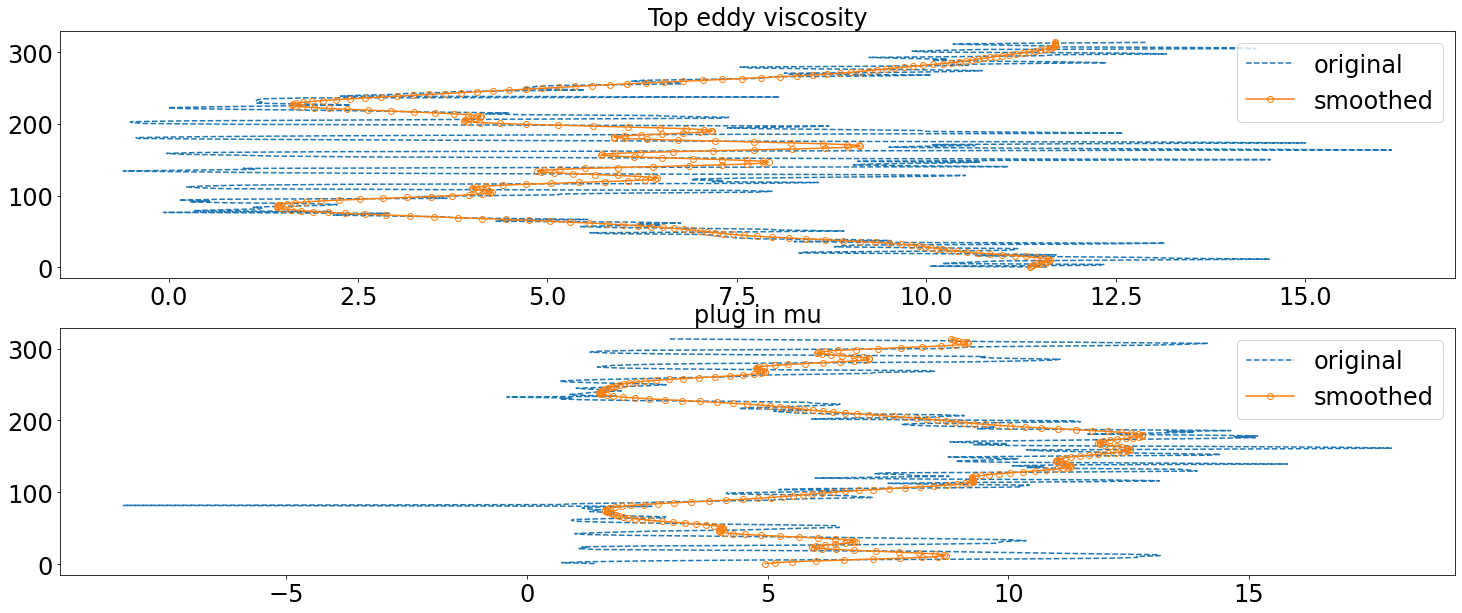

In [9]:
mu_mean_clip = np.copy(mu_mean)
mu_mean_clip[mu_mean_clip < 0] = 0
mu_mean_clip[0, :] = scipy.ndimage.gaussian_filter1d(mu_mean_clip[0, :], 5)
mu_mean_clip[1, :] = scipy.ndimage.gaussian_filter1d(mu_mean_clip[1, :], 5)


fig, ax = plt.subplots(2,figsize=(25,10))
ax[0].plot(mu_mean[0, :], yy, "--", fillstyle = "none", label="original")
ax[0].plot(mu_mean_clip[0, :], yy, "-o", fillstyle = "none", label="smoothed")
ax[0].legend()
ax[0].set_title("Top eddy viscosity")
ax[1].plot(mu_mean[1, :], yy, "--", fillstyle = "none", label="original")
ax[1].plot(mu_mean_clip[1, :], yy, "-o", fillstyle = "none", label="smoothed")
ax[1].legend()
ax[1].set_title("Bottom eddy viscosity")
plt.title("plug in mu")

In [13]:
# reset the resolution
def coarsen(v):
    if v.ndim == 2:
        n = v.shape[1]
        assert(n %2 == 0)
        return (v[:, 0::2] + v[:, 1::2])/2.0
    elif v.ndim == 1:
        n = len(v)
        assert(n %2 == 0)
        return (v[0::2] + v[1::2])/2.0
    else:
        print("coarsen v with dimension: ", v.ndim, " has not implemented")
    return v

dt = 4e-3 
save_every = 1000
Nt = 400000 
COARSEN_MESH = False
if COARSEN_MESH: 
    Ny = Ny//2
    force = coarsen(force)
    mu_mean_clip = coarsen(mu_mean_clip)
    yy = coarsen(yy)
    dt *= 2.0
    

# q0 = np.copy(q_mean)
q0 = np.zeros((2, Ny))
# q0[0, :] = 1e-1 * np.sin(2*np.pi*yy/L)
# q0[1, :] = 1e-1 * np.cos(2*np.pi*yy/L)

q0[0, :] = -beta*L/2 * np.sin(2*np.pi*yy/L)
q0[1, :] =  beta*L/2* np.cos(2*np.pi*yy/L)
    

def mu_model(x):
    return mu_mean_clip.flatten()


model = partial(nummodel_fft, mu_model, beta1, beta2)
yy, t_data, q_data = explicit_solve(model, force, q0, params, dt = dt, Nt = Nt, save_every = 1000)


200000 max q 437.2351587789174
400000 max q 428.6588811740965


Text(0.5, 1.0, 'average on last 1000 frames')

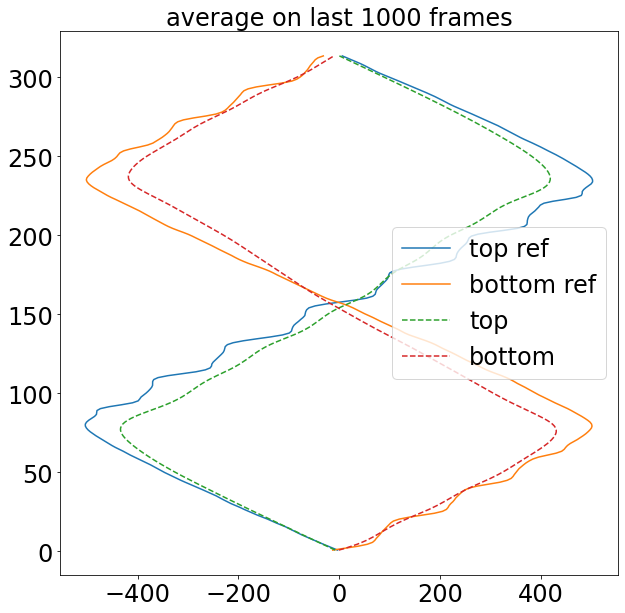

In [14]:
q_mean_ref = q_mean
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.plot(q_mean_ref[0, :], yy, label="top ref")
ax.plot(q_mean_ref[1, :], yy, label="bottom ref")

ax.plot(np.mean(q_data[Nt//(2*save_every):, 0, :], axis=0), yy, "--", label="top")
ax.plot(np.mean(q_data[Nt//(2*save_every):, 1, :], axis=0), yy, "--", label="bottom")

ax.legend()
plt.title("average on last 1000 frames")